# Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
! {sys.executable} -m pip install kaggle --upgrade

  Stored in directory: C:\Users\sanch\AppData\Local\pip\Cache\wheels\87\ea\09\173986e395d051411b9d547a69fe96cdc26208cb1bcc3e5567
  Stored in directory: C:\Users\sanch\AppData\Local\pip\Cache\wheels\16\7f\c3\6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


In [3]:
#! mkdir %sanchit05%\.kaggle
#! move kaggle.json %sanchit05%\.kaggle

In [3]:
# path = Config.data_path()/'planet'
# path.mkdir(parents=True, exist_ok=True)
# path

WindowsPath('C:/Users/sanch/.fastai/data/planet')

In [3]:
path= Path('C:/Users/sanch/.fastai/data/planet')

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [4]:
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sanch\.conda\envs\fastai_v1

  added / updated specs:
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         299 KB  haasad
    ------------------------------------------------------------
                                           Total:         299 KB

The following NEW packages will be INSTALLED:

  eidl7zip           haasad/win-64::eidl7zip-1.0.0-1




eidl7zip-1.0.0       | 299 KB    |            |   0% 
eidl7zip-1.0.0       | 299 KB    | 5          |   5% 
eidl7zip-1.0.0       | 299 KB    | #          |  11% 
eidl7zip-1.0.0       | 299 KB    | #6         |  16% 
eidl7zip-1.0.0       | 299 KB    | ###2       |  32% 
eidl7zip-1.0.0       | 299 KB    | ###7       |  37% 
eidl7zip-1.0.0       | 299 KB    | ####8      |  48% 
eidl7

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.


In [6]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


7-Zip (A) 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: C:\Users\sanch\.fastai\data\planet\train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05,max_warp=0)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

In [6]:
np.random.seed(42)
src = (ImageList.from_csv(path,'train_v2.csv',folder='train-jpg',suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
data= (src.transform(tfms,size=128)
      .databunch().normalize(imagenet_stats))

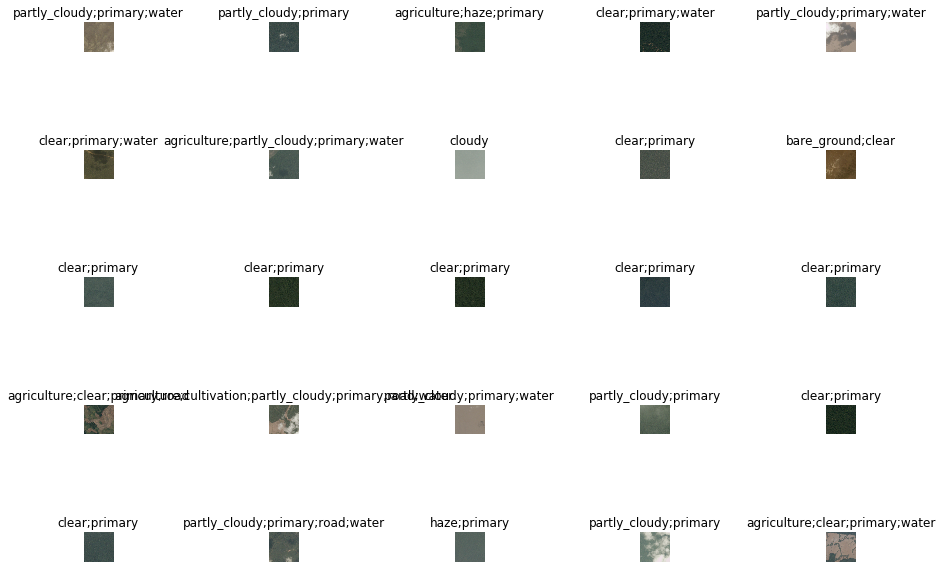

In [15]:
data.show_batch(row=2,figsize=(12,9))

In [8]:
arch = models.resnet34

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta,thresh=0.2)
learn = cnn_learner(data,arch, metrics =[acc_02,f_score])

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


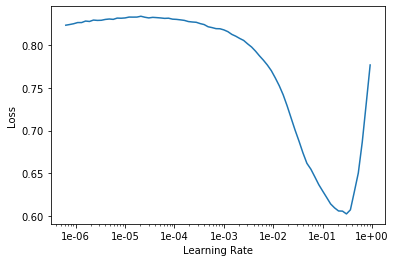

In [19]:
learn.recorder.plot()

In [20]:
lr= 0.01

In [22]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.129759,0.113855,0.944178,0.899659,10:53
1,0.117599,0.103325,0.948305,0.908963,05:20
2,0.107890,0.095525,0.949409,0.916061,05:18
3,0.103322,0.091867,0.950114,0.919363,05:23
4,0.098002,0.090484,0.953297,0.921426,05:22


In [23]:
learn.save('stage-1-rn34')

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


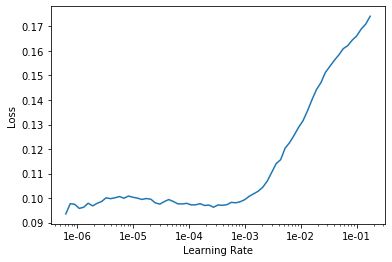

In [25]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.099938,0.093507,0.946074,0.917616,06:38
1,0.097429,0.092663,0.953959,0.918292,06:51
2,0.093605,0.088397,0.955375,0.924085,06:46
3,0.090390,0.085049,0.956131,0.926368,06:47
4,0.084705,0.084480,0.956444,0.925711,06:48


In [28]:
learn.save('stage-2-rn34')

In [12]:
learn.load('stage-2-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: C:\Users\sanch\.fastai\data\planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: C:\Users\sanch\.fastai\data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3

In [10]:
data = (src.transform(tfms,size=256)
       .databunch(bs=10).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [15]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


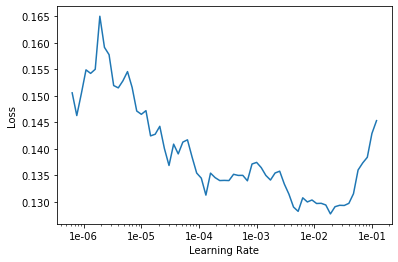

In [16]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr= 1e-2/2

In [19]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.119951,0.098964,0.959292,0.916440,19:03
1,0.112569,0.133180,0.961145,0.919369,17:56
2,0.106292,0.093177,0.956458,0.921882,21:31
3,0.099592,0.092338,0.957003,0.922852,19:16
4,0.098906,0.090075,0.960281,0.923733,23:11


In [20]:
learn.save('stage-1-256-rn34')

In [11]:
learn.load('stage-1-256-rn34')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: C:\Users\sanch\.fastai\data\planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: C:\Users\sanch\.fastai\data\planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3

In [12]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.117177,0.244319,0.952447,0.914257,41:56
1,0.103695,0.208684,0.956654,0.917396,26:13
2,0.108610,0.140105,0.959795,0.918444,25:47
3,0.096622,0.093830,0.959648,0.923246,25:51
4,0.095429,0.188638,0.957287,0.921444,25:53


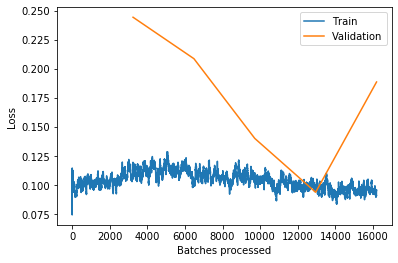

In [16]:
learn.recorder.plot_losses()

In [21]:
learn.save('stage-2-256-rn34')